# Roteiro Levenberg-Marquadt

Esse código é um protótipo de função para a implementação do algoritmo de Levenberg-Marquadt, o qual é utilizado para estimar parâmetros não-lineares. 

\begin{equation}
\Gamma (\textbf{m}) = \Psi (\textbf{m}) + \sum\limits^{6}_{j=1}\alpha_{j}\varphi_{j}(\textbf{m})
\end{equation}

In [1]:
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
import cPickle as pickle

from fatiando.gridder import regular
from copy import deepcopy
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.gravmag import prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
import mag_polyprism_functions as mfun
import polyprism_tests as tests
#% matplotlib inline

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


# Entrada

### Gerando os parâmetros verdadeiros

In [3]:
with open('../data/sphere_model.pickle') as w:
        sphere_model = pickle.load(w)
        

### Pontos de observação

In [4]:
with open('../data/regular_grid.pickle') as w:
        regular_grid = pickle.load(w)
        

# Gerando os dados preditos

In [5]:
with open('../data/sphere_data.pickle') as w:
        sphere_data = pickle.load(w)

### Parâmetros exigidos durante a inversão

In [6]:
a1 = 0.0   # adjacent radial distances within each prism
a2 = 0.0    # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 0.001   # vertically adjacent origins
a6 = 0.001   # zero order Tikhonov on adjacent radial distances

In [7]:
M = 20 # number of vertices per prism
L = 4 # number of prisms
P = L*(M+2) # number of parameters
dz = 25.

# limits for parameters in meters
rmin = 10.
rmax = 900.
x0min = -1000.
x0max = 1000.
y0min = -1000.
y0max = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max)

itmax = 30
itmax_marq = 10
epsilon = 1.0e-5     # convergence criterion
gamma = 1.0e-7

delta = 1. # increment of derivatives
m_out = np.zeros(M + 2)  # outcropping body parameters

inc = sphere_model['inc']
dec = sphere_model['dec']
dobs = sphere_data['data_noise']
xp = regular_grid['xp']
yp = regular_grid['yp']
zp = regular_grid['zp']
N = regular_grid['N']

rin = np.linspace(200.,200.,M)
rin = np.hstack((rin, np.zeros(2)))
m0 = np.resize(rin, P) # inicial parameters vector
model0 = mfun.param2polyprism(m0, M, L, 50., dz, sphere_model['props']) # list of classes of prisms
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec) # predict data
res = dobs - d0

In [8]:
print m0

[ 200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
  200.  200.  200.  200.  200.  200.  200.  200.    0.    0.  200.  200.
  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
  200.  200.  200.  200.  200.  200.    0.    0.  200.  200.  200.  200.
  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
  200.  200.  200.  200.    0.    0.  200.  200.  200.  200.  200.  200.
  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
  200.  200.    0.    0.]


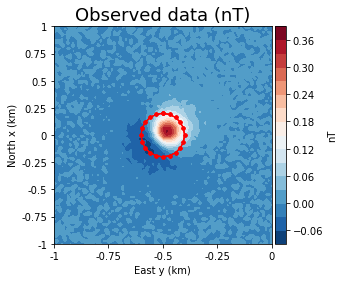

In [9]:
plt.title("Observed data (nT)", fontsize = 18)
plt.axis('scaled')
nlevels = mpl.contourf(regular_grid['yp'], regular_grid['xp'], sphere_data['data_noise'],\
                       regular_grid['shape'], 15, cmap='RdBu_r')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
plt.colorbar(pad=0.01, aspect=20, shrink=1.).set_label('nT')
#for p in sphere_model['prisms']:
#    mpl.polygon(p, '.-b', xy2ne=True)
for p in model0:
    mpl.polygon(p, '.-r', xy2ne=True)
mpl.m2km()
plt.savefig('observed_sphere_data.png', dpi=300)
plt.show()

In [10]:
G = mfun.Jacobian_tf(xp, yp, zp, model0, M, L, delta, delta, delta, inc, dec)
H = 2*np.dot(G.T, G)/N
th = np.trace(H)/P

In [11]:
%lprun -f mfun.Jacobian_tf mfun.Jacobian_tf(xp, yp, zp, model0, M, L, delta, delta, delta, inc, dec)

In [12]:
print th

9.49779988863e-08


In [13]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10000.*th
dlamb = 10.      # step for Marquadt's parameter

alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = mfun.norm_regul_param(M, L, th, m_out, a1, a2, a3, a4, a5, a6)
#alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = mfun.norm_regul_param(M, L, 1., m_out, a1, a2, a3, a4, a5, a6)


In [14]:
print alpha1
print alpha2
print alpha3
print alpha4
print alpha5
print alpha6

0.0
0.0
0.0
0.0
1.58296664811e-11
1.18722498608e-12


In [15]:
phi0 = np.sum(res*res)/N
phi0 += mfun.phi_1(M, L, m0, alpha1) + mfun.phi_2(M, L, m0, alpha2) + \
        mfun.phi_3(M, L, m0, m_out, alpha3) + mfun.phi_4(M, L, m0, m_out[-2:], alpha4) + \
        mfun.phi_5(M, L, m0, alpha5) + mfun.phi_6(M, L, m0, alpha6)
phi_list = [phi0]
    
i,j = np.diag_indices(P)
for it in range(itmax):
    #bounds = [-3000., 3000., -3000., 3000., -1000.0, 4000.]

    #red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
    #white, black = (1, 1, 1), (0, 0, 0),
    #scene = myv.figure()
    #myv.polyprisms(sphere_model['prisms'], 'magnetization', color=blue, linewidth=1., style='wireframe', opacity=.3)
    #myv.polyprisms(model0, 'magnetization', color=red, linewidth=3.5)

    #ax = myv.axes(myv.outline(bounds), ranges=[t * 0.001 for t in bounds])
    #ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (cm)', 'y (cm)', 'z (cm)'
    #ax.axes.font_factor = 1.5
    #scene.scene.camera.position = [-0.089204656936016313, -0.066107174155361687, -0.04083578885723696]
    #scene.scene.camera.focal_point = [1.1820671636724554e-16, 1.3134079596360617e-17, -1.9701119394540926e-17]
    #scene.scene.camera.view_angle = 30.0
    #scene.scene.camera.view_up = [0.24683390337942718, 0.24593292331329802, -0.93733132955911114]
    #scene.scene.camera.clipping_range = [0.057117737884348194, 0.1956040854922288]
    #scene.scene.camera.compute_view_plane_normal()

    #myv.wall_bottom(ax.axes.bounds, opacity=0.2)
    #myv.wall_north(ax.axes.bounds)
        
    #myv.savefig('bolacha'+`it`+'.png')
    
    mt = mfun.trans_parameter2(m0, M, L, mmax, mmin)
        
    # Jacobian matrix
    G = mfun.Jacobian_tf(xp, yp, zp, model0, M, L, delta, delta, delta, inc, dec)
    
    # Hessian matrix
    H = 2.*np.dot(G.T, G)/N

    #prec = np.diagonal(H).copy()
    #mask = prec < 1e-10
    #prec[mask] = 1e-10
    #H[:,j] /= prec    

    H = mfun.Hessian_phi_1(M, L, H, alpha1)
    H = mfun.Hessian_phi_2(M, L, H, alpha2)
    H = mfun.Hessian_phi_3(M, L, H, alpha3)
    H = mfun.Hessian_phi_4(M, L, H, alpha4)
    H = mfun.Hessian_phi_5(M, L, H, alpha5)
    H = mfun.Hessian_phi_6(M, L, H, alpha6)
    
    # gradient vector
    grad = -2.*np.dot(G.T, res)/N

    grad = mfun.gradient_phi_1(M, L, grad, alpha1)
    grad = mfun.gradient_phi_2(M, L, grad, alpha2)
    grad = mfun.gradient_phi_3(M, L, grad, m_out, alpha3)
    grad = mfun.gradient_phi_4(M, L, grad, m_out[-2:], alpha4)
    grad = mfun.gradient_phi_5(M, L, grad, alpha5)
    grad = mfun.gradient_phi_6(M, L, grad, alpha6)
    
    # positivity matrix diagonal
    T = ((mmax - m0 + 1e-10)*(m0 - mmin + 1e-10))/(mmax - mmin)
    
    for it_marq in range(itmax_marq): 

        #S = H.copy()
        #S = H[:,:]
        #S[i,:] *= T
        #S[i,j] += lamb

        delta_mt = np.linalg.solve(H*np.identity(P)*(T + lamb), -grad)
        #print delta_mt.shape
        #print np.min(delta_mt)
        
        # criar teste pra esta função
        m_est = mfun.trans_inv_parameter2(mt + delta_mt, M, L, mmax, mmin)
        #print m_est.shape
        #m_est = m0 + delta_mt

        model_est = mfun.param2polyprism(m_est, M, L, 50., dz, sphere_model['props'])

        d_fit = polyprism.tf(xp, yp, zp, model_est, inc, dec)
        res = dobs - d_fit
        phi = np.sum(res*res)/N
        phi += mfun.phi_1(M, L, m_est, alpha1) + mfun.phi_2(M, L, m_est, alpha2) + \
                mfun.phi_3(M, L, m_est, m_out, alpha3) + mfun.phi_4(M, L, m_est, m_out[-2:], alpha4) + \
                mfun.phi_5(M, L, m_est, alpha5) + mfun.phi_6(M, L, m_est, alpha6)
        dphi = phi - phi0
        
        print '%3d %.5e %3d %.e' % (it, phi, it_marq, lamb)
        
        if (dphi > 0.):
            lamb *= dlamb
        else:
            if lamb/dlamb < 1e-15:
                lamb = 1e-15
            else:
                lamb /= dlamb
            break
            
    if (abs(dphi)/phi0 < epsilon):
        phi_list.append(phi)
        break
    else:
        d0 = d_fit
        m0 = m_est
        model0 = model_est
        phi0 = phi
        phi_list.append(phi0)

  0 8.77118e-04   0 9e-06
  1 3.20727e+00   0 9e-07
  1 3.20727e+00   1 9e-06
  1 3.20727e+00   2 9e-05
  1 3.20727e+00   3 9e-04
  1 3.20727e+00   4 9e-03
  1 3.20727e+00   5 9e-02
  1 3.20727e+00   6 9e-01
  1 3.20727e+00   7 9e+00
  1 3.20721e+00   8 9e+01
  1 8.15546e-04   9 9e+02
  2 3.06780e+00   0 9e+01
  2 1.27014e-03   1 9e+02
  2 7.94225e-04   2 9e+03
  3 2.32242e-03   0 9e+02
  3 7.68104e-04   1 9e+03
  4 3.81712e-03   0 9e+02
  4 7.36697e-04   1 9e+03
  5 5.51905e-03   0 9e+02
  5 6.99783e-04   1 9e+03
  6 7.02284e-03   0 9e+02
  6 6.57460e-04   1 9e+03
  7 7.97838e-03   0 9e+02
  7 6.10220e-04   1 9e+03
  8 8.18717e-03   0 9e+02
  8 5.58950e-04   1 9e+03
  9 7.50294e-03   0 9e+02
  9 5.04891e-04   1 9e+03
 10 6.11919e-03   0 9e+02
 10 4.49579e-04   1 9e+03
 11 4.50242e-03   0 9e+02
 11 3.94738e-04   1 9e+03
 12 3.09087e-03   0 9e+02
 12 3.42098e-04   1 9e+03
 13 1.99347e-03   0 9e+02
 13 2.93171e-04   1 9e+03
 14 1.20440e-03   0 9e+02
 14 2.49089e-04   1 9e+03
 15 6.99884e

In [16]:
print delta_mt

[-0.01946352 -0.01555959 -0.01312106 -0.01295519 -0.01523519 -0.01978524
 -0.02504505 -0.02864777 -0.02921451 -0.02652139 -0.02163823 -0.01665189
 -0.01351712 -0.01262938 -0.01369329 -0.01672623 -0.0207286  -0.02387595
 -0.02482054 -0.02308865  0.0005647  -0.00055769 -0.023654   -0.01781572
 -0.01429002 -0.01411275 -0.01660829 -0.02273463 -0.02957499 -0.03499249
 -0.03629925 -0.03227186 -0.02584988 -0.01915709 -0.01510533 -0.01435335
 -0.01577773 -0.02053559 -0.02627668 -0.031229   -0.03267439 -0.02924562
  0.00082963 -0.00060085 -0.02824803 -0.01861168 -0.01288238 -0.01228529
 -0.01489767 -0.02346029 -0.0331398  -0.04194974 -0.04445094 -0.03820937
 -0.02879792 -0.01930689 -0.01397576 -0.01369555 -0.015882   -0.02398992
 -0.03326686 -0.04182898 -0.04417661 -0.03779712  0.00045878  0.00031223
 -0.03274679 -0.01798879 -0.00934609 -0.00680092 -0.00820726 -0.01642811
 -0.02820181 -0.03907171 -0.04195036 -0.03484773 -0.02279087 -0.01212171
 -0.00770265 -0.00909098 -0.01342716 -0.02570545 -0

In [17]:
for i, (mv, mm) in enumerate(zip(m0,mmin)):
    if mv<=mm:
        print '%.15e,%.e' % (mv,i)

In [18]:
print delta_mt

[-0.01946352 -0.01555959 -0.01312106 -0.01295519 -0.01523519 -0.01978524
 -0.02504505 -0.02864777 -0.02921451 -0.02652139 -0.02163823 -0.01665189
 -0.01351712 -0.01262938 -0.01369329 -0.01672623 -0.0207286  -0.02387595
 -0.02482054 -0.02308865  0.0005647  -0.00055769 -0.023654   -0.01781572
 -0.01429002 -0.01411275 -0.01660829 -0.02273463 -0.02957499 -0.03499249
 -0.03629925 -0.03227186 -0.02584988 -0.01915709 -0.01510533 -0.01435335
 -0.01577773 -0.02053559 -0.02627668 -0.031229   -0.03267439 -0.02924562
  0.00082963 -0.00060085 -0.02824803 -0.01861168 -0.01288238 -0.01228529
 -0.01489767 -0.02346029 -0.0331398  -0.04194974 -0.04445094 -0.03820937
 -0.02879792 -0.01930689 -0.01397576 -0.01369555 -0.015882   -0.02398992
 -0.03326686 -0.04182898 -0.04417661 -0.03779712  0.00045878  0.00031223
 -0.03274679 -0.01798879 -0.00934609 -0.00680092 -0.00820726 -0.01642811
 -0.02820181 -0.03907171 -0.04195036 -0.03484773 -0.02279087 -0.01212171
 -0.00770265 -0.00909098 -0.01342716 -0.02570545 -0

In [19]:
res_norm = (res - np.mean(res))/np.std(res)

In [20]:
np.mean(res_norm), np.std(res_norm)

(8.8817841970012525e-18, 1.0)

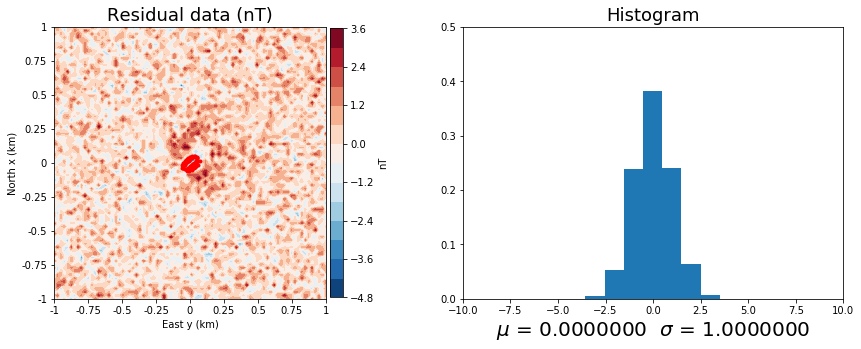

In [21]:
#ddif = dobs - d0
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Residual data (nT)", fontsize = 18)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res_norm,regular_grid['shape'], 15, cmap='RdBu_r')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
plt.colorbar(pad=0.01, aspect=20, shrink=0.99).set_label('nT')
#for p in sphere_model['prisms']:
#    mpl.polygon(p, '.-b', xy2ne=True)
for p in model_est:
    mpl.polygon(p, '.-r', xy2ne=True)
mpl.m2km()
#plt.savefig('residual_data.png', dpi=300)
plt.subplot(1,2,2)
#plt.axis('auto')
plt.title('Histogram', fontsize = 18)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
plt.hist(res_norm,bins=nbins, normed=True)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.savefig('fit_hist.png', dpi=300)
plt.show()

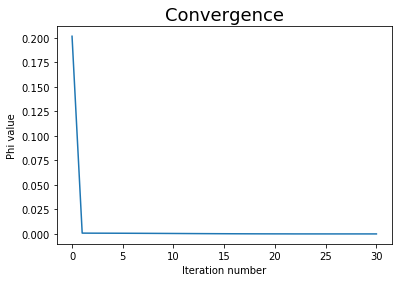

In [22]:
plt.title('Convergence', fontsize = 18)
plt.xlabel('Iteration number')
plt.ylabel('Phi value')
plt.plot(phi_list)
plt.savefig('convergence_sphere.png', dpi=300)
plt.show()

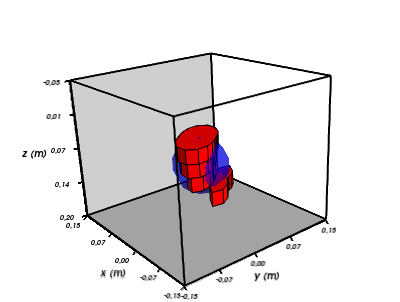

In [23]:
bounds = [-150., 150., -150., 150., -50., 200.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
myv.points([sphere_model['x'],sphere_model['y'], sphere_model['z']], color=blue, size=50.0, opacity=0.5, 
           spherical=False)
myv.polyprisms(model0, 'magnetization', color=red, linewidth=1.)

ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (m)', 'y (m)', 'z (m)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-0.089204656936016313, -0.066107174155361687, -0.04083578885723696]
scene.scene.camera.focal_point = [1.1820671636724554e-16, 1.3134079596360617e-17, -1.9701119394540926e-17]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.24683390337942718, 0.24593292331329802, -0.93733132955911114]
scene.scene.camera.clipping_range = [0.057117737884348194, 0.1956040854922288]
scene.scene.camera.compute_view_plane_normal()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
myv.savefig('bolacha_sphere.png')
myv.show()

img(filename='bolacha_sphere.png')

In [24]:
np.identity(P)*np.linspace(1,P+2, P)

array([[  1.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   2.02298851,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   3.04597701, ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,  87.95402299,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
         88.97701149,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  90.        ]])

In [25]:
np.linspace(1,P+2, P)

array([  1.        ,   2.02298851,   3.04597701,   4.06896552,
         5.09195402,   6.11494253,   7.13793103,   8.16091954,
         9.18390805,  10.20689655,  11.22988506,  12.25287356,
        13.27586207,  14.29885057,  15.32183908,  16.34482759,
        17.36781609,  18.3908046 ,  19.4137931 ,  20.43678161,
        21.45977011,  22.48275862,  23.50574713,  24.52873563,
        25.55172414,  26.57471264,  27.59770115,  28.62068966,
        29.64367816,  30.66666667,  31.68965517,  32.71264368,
        33.73563218,  34.75862069,  35.7816092 ,  36.8045977 ,
        37.82758621,  38.85057471,  39.87356322,  40.89655172,
        41.91954023,  42.94252874,  43.96551724,  44.98850575,
        46.01149425,  47.03448276,  48.05747126,  49.08045977,
        50.10344828,  51.12643678,  52.14942529,  53.17241379,
        54.1954023 ,  55.2183908 ,  56.24137931,  57.26436782,
        58.28735632,  59.31034483,  60.33333333,  61.35632184,
        62.37931034,  63.40229885,  64.42528736,  65.44

In [26]:
# limits for parameters in meters
rmin = 10.
rmax = 6000.
x0min = -5000.
x0max = 5000.
y0min = -5000.
y0max = 5000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max)

In [27]:
print alpha6

In [28]:
p = np.linspace(-5000., 5000.,P)
pt = - np.log((x0max - p)/(p - x0min))

In [29]:
print pt

In [30]:
pi = x0min + (x0max - x0min)/(1+np.exp(-pt))

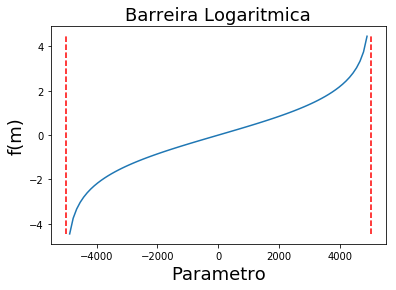

In [31]:
plt.title('Barreira Logaritmica', fontsize = 18)
plt.xlabel('Parametro', fontsize = 18)
plt.ylabel('f(m)', fontsize = 18)
plt.plot(pi,pt)
plt.plot(np.zeros(P)+5000., pt, 'r--')
plt.plot(np.zeros(P)-5000., pt, 'r--')
plt.savefig('bar_t.png', dpi=300)
plt.show()

In [32]:
print pi

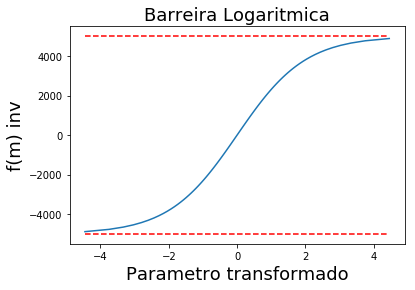

In [33]:
plt.title('Barreira Logaritmica', fontsize = 18)
plt.xlabel('Parametro transformado', fontsize=18)
plt.ylabel('f(m) inv', fontsize=18)
plt.plot(pt,p)
plt.plot(pt, np.zeros(P)+5000., 'r--')
plt.plot(pt, np.zeros(P)-5000., 'r--')
plt.savefig('bar_ti.png', dpi=300)
plt.show()

In [34]:
c = mfun.Hessian_phi_6(3, 2, np.zeros((10,10)), 1.)

In [35]:
c = np.dot(c,c)

In [36]:
np.dot(c, np.ones(10))

array([ 1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.])

In [37]:
m = np.ones(15)

In [38]:
P = 3*(3 + 2)

m6 = m.copy()

# extracting the non-zero diagonals
d0 = mfun.diags_phi_6(3, 3, .5)

# calculating the product between the diagonals and the slices of m
m6 = m*d0
print m6, m
phi_6 = np.dot(m6, m)
print phi_6

In [39]:
w = 3.
o = w - 1e-15
(10.-w)/(w - o)

7881299347898368.0

In [40]:
u = -np.log((10.-w)/(w - o))

In [41]:
1./np.exp(-u)

1.2688263138573182e-16

# Algoritmo Levenberg-Marquadt

1- Iteração $k=0$: chute inicial $\mathbf{m}_0$ em que todos os elementos satisfaçam os vínculos de desigualdade e um valor real positivo grande para $\lambda$

2) Calcula os parâmetros transformados $\breve{\mathbf{m}}_k$

Os parâmetros transformados são calculados a partir da equação:

\begin{equation}
\breve{m}_i = f(m_i) = - \ln\left(\frac{m_{i\, max} - m_i}{m_i - m_{i\, min}}\right)
\end{equation}

A transformação inversa dos parâmetros é dada pela equação:

\begin{equation}
m_i = f^{-1}(\breve{m}_i) = m_{i\, min} + \left(\frac{m_{i\, max} - m_{i\, min}}{1 + e^{-\breve{m}_i}}\right)
\end{equation}

3) laço externo: calcula $\nabla^2\Gamma (\hat{\mathbf{m}}_k)$, $\nabla\Gamma (\hat{\mathbf{m}}_k)$ e $T(\hat{\mathbf{m}}_k)$:

a) laço interno: calcula $\Delta \breve{\mathbf{m}}_k$ solucionando o sistema linear abaixo

\begin{equation}
\left[\nabla^2\Gamma (\hat{\mathbf{m}}_k)\mathbf{T}(\hat{\mathbf{m}}_k) + \lambda \mathbf{I} \right] \Delta\breve{\mathbf{m}}_k \approx - \nabla \Gamma (\hat{\mathbf{m}}_k)
\end{equation}

onde $\mathbf{T}(\hat{\mathbf{m}}_k)$ é uma matriz diagonal
\begin{equation}
[\mathbf{T}(\hat{\mathbf{m}}_k)]_{ii} = \frac{(m_{i\, max} - m_i)(m_i - m_{i\, min})}{(m_{i\, max} - m_{i\, min})}
\end{equation}

b) calcula $\breve{\mathbf{m}}_{k+1} = \breve{\mathbf{m}}_k + \Delta\breve{\mathbf{m}}_k$

c) computa $\hat{\mathbf{m}}_{k+1}$

d) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ 

   i $\lambda = \lambda\cdot d\lambda$

   ii retorne para 3)a)

e) $\lambda = \lambda/d\lambda$

4) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ e $\frac{|\Gamma (\hat{\mathbf{m}}_{k+1})- \Gamma (\hat{\mathbf{m}}_k)|}{|\Gamma (\hat{\mathbf{m}}_k)|}>\varepsilon$

a) $k=k+1$

b) Retorne para etapa 2)